## Sinkhorn bridges via OTT-JAX

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from toydatasets import *

plt.rcParams.update({'font.size': 20})

import jax
import jax.numpy as jnp
import ott
from ott.geometry import pointcloud
from ott.solvers import linear


## Sinkhorn bridge between 2D toy datasets

The 2D toy datasets function includes the following options: 'checkerboard', 'swissroll', 'circles', 'rings', 'moons', '8gaussians', 'pinwheel', and '2spirals'.

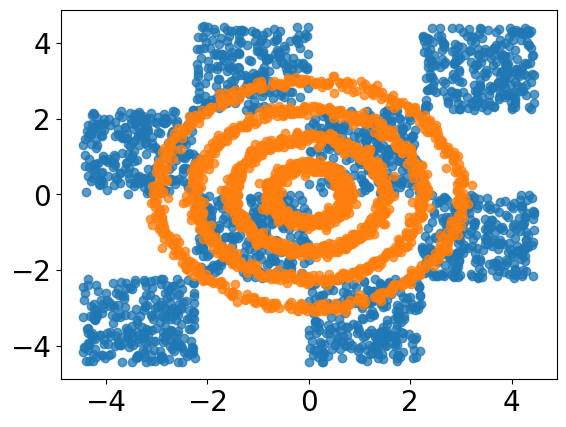

In [2]:
dim = 2
Ntrain = 2000

source_name = 'rings'
target_name = 'checkerboard'

source = ToyDatasets(source_name)  
target = ToyDatasets(target_name)

xdata = source.sample_joint(Ntrain)
ydata = target.sample_joint(Ntrain)

plt.scatter(ydata[:,0],ydata[:,1],alpha=0.75)
plt.scatter(xdata[:,0],xdata[:,1],alpha=0.75)

First we use OTT-JAX to compute the potentials defined on the in-sample target points, which will be stored and used in the drift. This is also where we set the base regularization parameter $\varepsilon > 0$ which governs the overall shape of the bridge. 

In [3]:
eps = 0.1
geom_data = pointcloud.PointCloud(jnp.array(xdata), jnp.array(ydata),epsilon=eps)
output = linear.solve(geom_data)
gYjs = output.potentials[1]

## Defining the drift

The drift that defines the Sinkhorn bridge hinges on the fitted potentials $(\hat{f},\hat{g})$ that solve the static problem. Here we express the drift succinctly as a function of the target sample points and $\hat{g}$, and use vmapping to extend the function to batches of points. Note that 'eps' has to be the same parameter as the one used to compute the fitted potentials.

In [4]:
def drift(x,target_train,pots_g,eps,t):   
    cost = (jnp.linalg.norm(x - target_train,ord=2,axis=1)**2)/t
    cond_prob = jax.nn.softmax( (pots_g - cost)/eps )
    return (-x + jnp.sum(target_train*cond_prob.reshape(-1,1),axis=0))/t

vmap_drift = jax.vmap(drift, in_axes=(0, None, None, None, None))

Then we initialize at new points, and run a standard Euler--Maruyama discretization of the SDE. The hyperparameters, namely 'tau' and 'Nsteps' can be varied as needed. The parameter 'tau' denotes how long along the bridge we want to traverse, and 'Nsteps' denotes the number of steps that will be taken to appropriately discretize the trajectory.

We then draw 'Ntest' many new points from the source distribution, and iterate over the Euler--Maruyama dynamics defined with respect to the above drift function.

In [5]:
tau = 0.9
Nsteps = 50

Ntest = 5000

xinit = jnp.array(source.sample_joint(Ntest))
dt = tau/Nsteps
k=0
t=0.0

x = xinit.copy()

xiters = jnp.zeros((Nsteps+1,xinit.shape[0],xinit.shape[1]))
xiters = xiters.at[0].set(x)
while k < Nsteps+1:
    bteps_x = vmap_drift(x,ydata,gYjs,eps,1-t)
    eta = jnp.array(np.random.multivariate_normal(jnp.zeros(dim), jnp.eye(dim), size=xinit.shape[0]))
    x += (dt * bteps_x) + np.sqrt(dt * eps)*eta
    k += 1
    t = k*dt
    xiters = xiters.at[k].set(x)

The following cell generates plots across the time marginals.

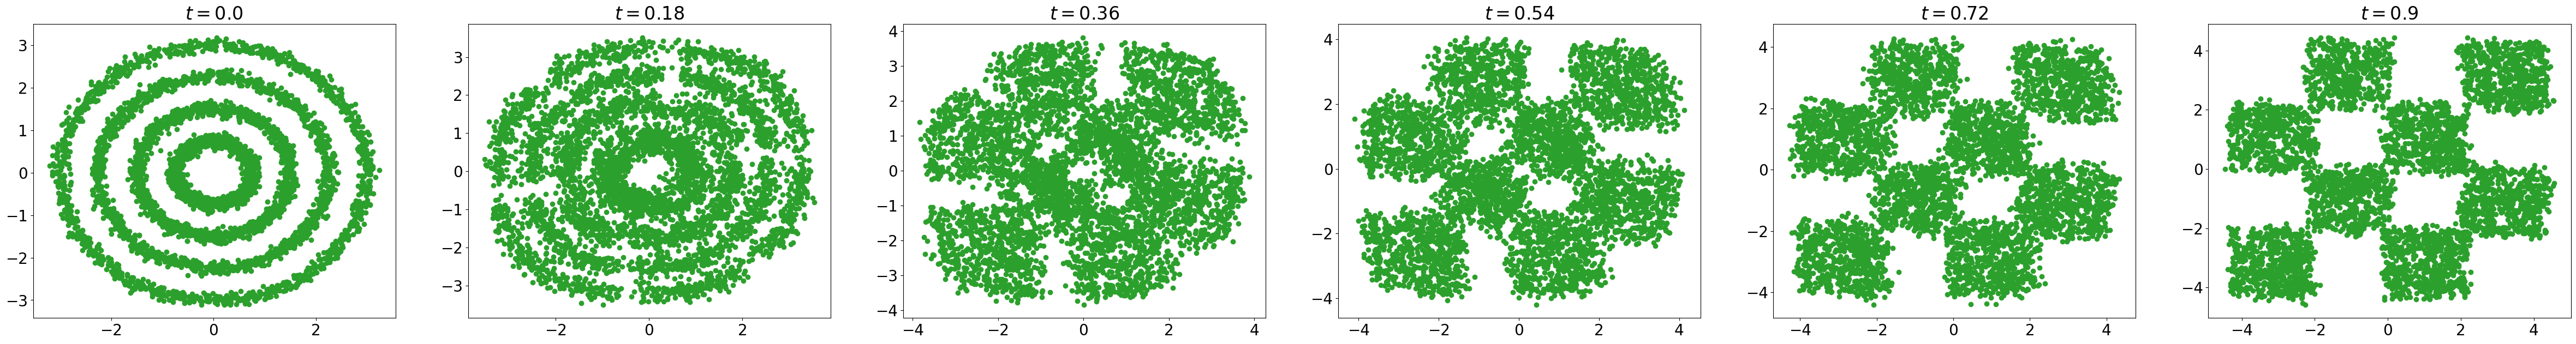

In [6]:
Nsplits = 5
jump = int(Nsteps/Nsplits)
fig, axs = plt.subplots(1, Nsplits+1, figsize=(60, 7))
j = 0

for i in range(Nsplits+1):
    j = min(i*jump,Nsteps)
    axs[i].scatter(xiters[j,:,0],xiters[j,:,1],c='#2ca02c')
    tcur = round(j/Nsteps * tau, 2)
    axs[i].set_title(r'$t={}$'.format(tcur)) 
plt.savefig('from_{}_to_{}_OTT.png'.format(source_name,target_name),format='png',dpi=300)